## Compartment model, time to max concentration, c-optimal

In [1]:
using PyPlot
using LinearAlgebra

#objective function h to minimize
function infmat(x)
    n = Int((length(x)+1)/2)
    a = x[1:n]
    b = x[(n+1):(2*n-1)]
    b = [b; 1-sum(b)]
    p = length(theta)
    mat = zeros(p,p)
    for i in 1:n
        c1 = a[i]*theta[3]*exp(-theta[1]*a[i])
        c2 = -a[i]*theta[3]*exp(-theta[2]*a[i]) 
        c3 = exp(-theta[2]*a[i])-exp(-theta[1]*a[i])
        f = [c1, c2, c3]
        mat = mat + b[i] .* f*f'
    end
    return mat
end

# projection function onto the design space
function proj(x, design)
    n = Int((length(x)+1)/2)
    a = x[1:n]
    b = x[(n+1):(2*n-1)]
    b = [b; 1-sum(b)]
    
    a = max.(a,design[1])
    a = min.(a,design[2])
    
    u = sort(b, rev=true)
    j = n
    while true
        if u[j] + 1/j*(1-cumsum(u)[j]) > 0
            break
        end
        j -= 1
    end
    lambda = 1/j*(1-cumsum(u)[j])
    b = max.(b .+ lambda,0)
    b = b[1:(n-1)]
    
    return [a;b]
end

proj (generic function with 1 method)

In [2]:
#objective function h
function h(x, c)
    mat = infmat(x)
    m = size(mat)[1]
    mat = mat + 10.0^-6* Diagonal(ones(m,m))
    return c' * inv(mat)* c
end

h (generic function with 1 method)

In [3]:
function citer()
    #initialize
    #srand(1992)
    path = zeros(niter)
    tau = 0.9:(-0.5/niter):0.4
    v = zeros(nptc, 2k-1)
    x = (design[2]-design[1])*rand(nptc*k) .+ design[1]
    x = reshape(x,nptc,k)
    w = rand(nptc*(k-1))
    w = reshape(w,nptc,(k-1))
    ptc = hcat(x,w)
    for j in 1:nptc
        ptc[j,:] = proj(ptc[j,:],design)
    end
    pbest = ptc
    pbesth = zeros(nptc)
    for i in 1:nptc
        pbesth[i] = h(pbest[i,:],c)
    end
    gbesth = findmin(pbesth)[1]
    gbest = pbest[findmin(pbesth)[2],:]

    #iterate
    t1 = time_ns()
    for i in 1:niter # iteration number
        for j in 1:nptc # particle number
            v[j,:] = tau[i] .*v[j,:] + 2 .*rand(2k-1) .*(pbest[j,:]-ptc[j,:]) + 2 .*rand(2k-1) .*(gbest-ptc[j,:])
            ptc[j,:] = ptc[j,:] + v[j,:]
            ptc[j,:] = proj(ptc[j,:], design)
            fit = h(ptc[j,:],c)
            if fit[1] < gbesth
                gbest = pbest[j,:] = ptc[j,:]
                gbesth = pbesth[j] = fit[1]
            elseif fit[1] < pbesth[j]
                pbest[j,:] = ptc[j,:]
                pbesth[j] = fit[1]
            end
        end
        path[i] = gbesth
    end
    t2 = time_ns()
    supp = gbest[1:k]
    prob = gbest[(k+1):2k-1]
    prob = [prob; 1-sum(prob)]
    plt = plot(1:niter, path, color="red", linewidth=2.0, linestyle="solid")
    cput = (t2-t1)/10^9
    return [supp, prob, cput, path[niter], path[niter] - path[niter-Int(0.1*niter)], plot]
end

citer (generic function with 1 method)

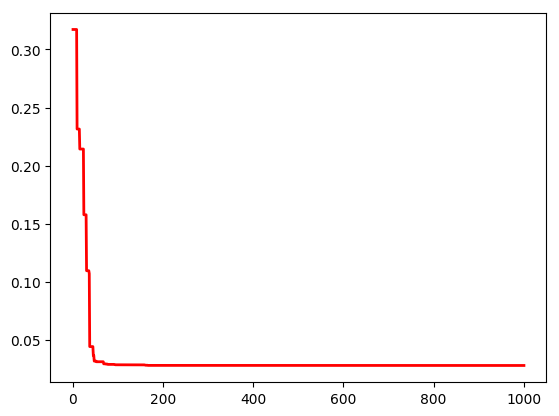

6-element Array{Any,1}:
  [3.56583, 0.179288]
  [0.39384, 0.60616] 
 6.306035804         
 0.02813827777732288 
 0.0                 
  PyPlot.plot        

In [4]:
theta = [0.05884, 4.298, 21.8]
k = 2
nptc = 200
niter = 1000
design = [0,10]

#derivative of function c(theta)
c = zeros(3)
c[1] = (1 - theta[2]/theta[1] - log(theta[1]) + log(theta[2])) / (theta[2]-theta[1])^2
c[2] = (1 - theta[1]/theta[2] - log(theta[2]) + log(theta[1])) / (theta[2]-theta[1])^2

citer()

## Compartment model, AUC, c-optimal

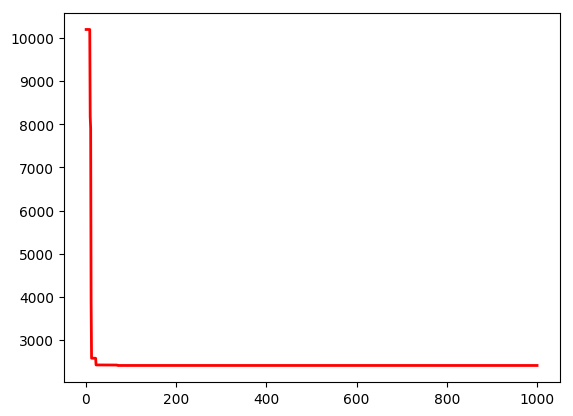

6-element Array{Any,1}:
     [0.870567, 20.0]     
     [0.0533834, 0.946617]
    3.015180137           
 2412.7398330920037       
    0.0                   
     PyPlot.plot          

In [5]:
theta = [0.05884, 4.298, 21.8]
k = 2
nptc = 100
niter = 1000
design = [0,20]

#derivative of function c(theta)
c = zeros(3)
c[1] = theta[3]/theta[1]^2
c[2] = -theta[3]/theta[2]^2
c[3] = 1/theta[2] - 1/theta[1]

citer()

## Compartment model, AUC, c-optimal What if design is [0,30]?

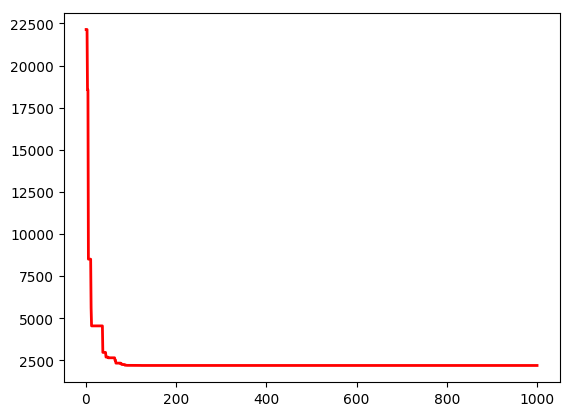

6-element Array{Any,1}:
     [17.634, 0.232672]   
     [0.986498, 0.0135025]
    2.988688998           
 2193.883929868683        
    0.0                   
     PyPlot.plot          

In [6]:
theta = [0.05884, 4.298, 21.8]
k = 2
nptc = 100
niter = 1000
design = [0,30]

citer()

## Compartment model, AUC, c-optimal (k=3)

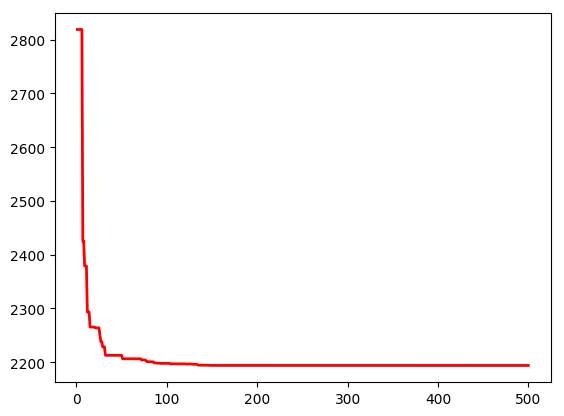

6-element Array{Any,1}:
     [17.634, 20.0, 0.232674]  
     [0.986498, 0.0, 0.0135024]
    3.171198286                
 2193.8839298998287            
    0.0                        
     PyPlot.plot               

In [7]:
theta = [0.05884, 4.298, 21.8]
k = 3
nptc = 200
niter = 500
design = [0,20]

citer()

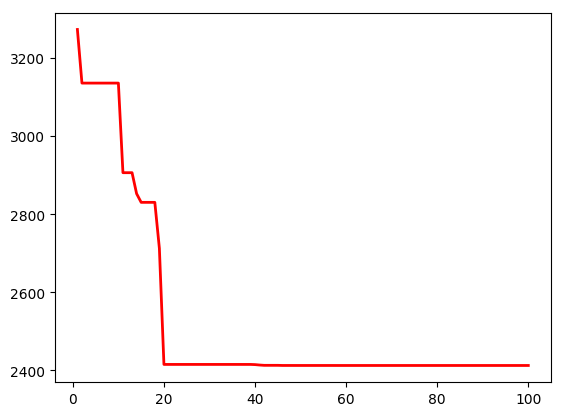

6-element Array{Any,1}:
     [20.0, 0.0, 0.870567]     
     [0.946617, 0.0, 0.0533832]
    0.321859464                
 2412.7398331062923            
   -1.672287908149883e-8       
     PyPlot.plot               

In [8]:
theta = [0.05884, 4.298, 21.8]
k = 3
nptc = 100
niter = 100
design = [0,20]

citer()

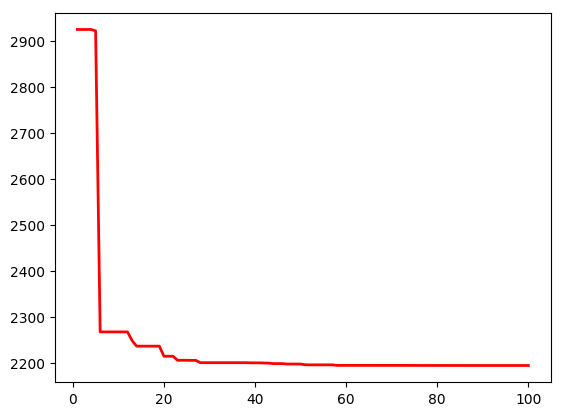

6-element Array{Any,1}:
     [9.0252, 17.634, 0.232676, 20.0]
     [0.0, 0.986503, 0.0134975, 0.0] 
    0.354902934                      
 2193.8839366070742                  
   -0.0005926359826844418            
     PyPlot.plot                     

In [9]:
theta = [0.05884, 4.298, 21.8]
k = 4
nptc = 100
niter = 100
design = [0,20]

citer()

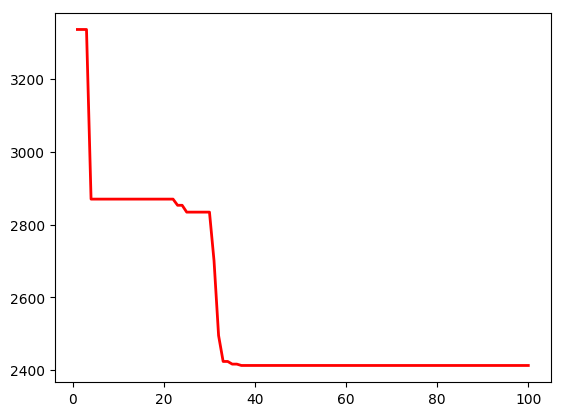

6-element Array{Any,1}:
     [0.0, 20.0, 0.870567, 0.0, 20.0]         
     [0.0, 0.769008, 0.0533834, 0.0, 0.177608]
    0.355407819                               
 2412.739833105976                            
   -1.2560576578835025e-8                     
     PyPlot.plot                              

In [10]:
theta = [0.05884, 4.298, 21.8]
k = 5
nptc = 100
niter = 100
design = [0,20]

citer()

## Stability (1000 iteration)

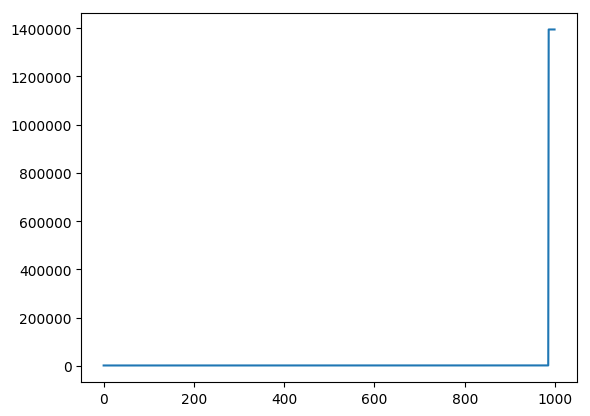

Summary Stats:
Length:         1000
Missing Count:  0
Mean:           21849.284622
Minimum:        2193.883930
1st Quartile:   2193.883930
Median:         2412.739833
3rd Quartile:   2412.739833
Maximum:        1394801.834394
Type:           Float64


In [11]:
using NPZ
using PyPlot
using StatsBase

result1 = npzread("result1.npy")
plot(sort(result1[:,6]))
describe(result1[:,6])

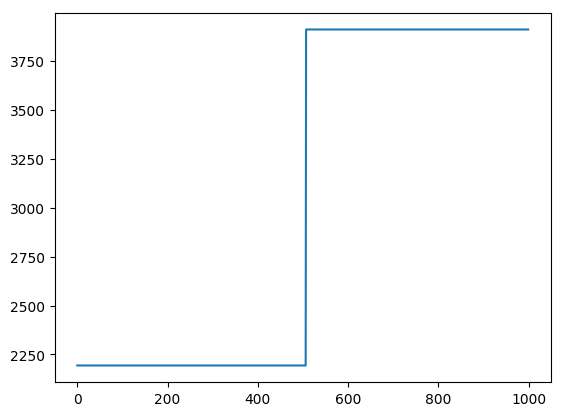

Summary Stats:
Length:         1000
Missing Count:  0
Mean:           3039.689203
Minimum:        2193.883930
1st Quartile:   2193.883930
Median:         2193.883930
3rd Quartile:   3909.513287
Maximum:        3909.513287
Type:           Float64


In [12]:
result2 = npzread("result2.npy")
plot(sort(result2[:,6]))
describe(result2[:,6])